In [31]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [33]:
# Cell 1: Define the main simulation function
def generate_simulation_data(n_samples=500, n_replicates=3, scenario=1, seed=None):
    """
    Generate simulation data with measurement error as described in the paper.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_replicates : int
        Number of replicates with measurement error
    scenario : int
        1 for uncorrelated replicates (c_e = 0)
        2 for correlated replicates (c_e = 0.8)
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    DataFrame with true covariates, replicates with measurement error, and response variables
    """
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Step 1: Generate "true" covariates
    x_true = np.random.normal(0, 5, n_samples)
    
    # Step 2: Set up measurement error parameters
    sigma_sq_me_1 = 1  # For the first half of the samples
    sigma_sq_me_2 = 2  # For the second half of the samples
    
    # Correlation parameter
    c_e = 0 if scenario == 1 else 0.8
    
    # Create the Sigma_me matrices
    def create_sigma_me(sigma_sq_me):
        Sigma_me = np.zeros((n_replicates, n_replicates))
        for i in range(n_replicates):
            for j in range(n_replicates):
                if i == j:
                    Sigma_me[i, j] = sigma_sq_me
                else:
                    Sigma_me[i, j] = c_e * sigma_sq_me
        return Sigma_me
    
    Sigma_me_1 = create_sigma_me(sigma_sq_me_1)
    Sigma_me_2 = create_sigma_me(sigma_sq_me_2)
    
    # Step 3: Generate replicates with measurement error
    x_replicates = np.zeros((n_samples, n_replicates))
    
    for i in range(n_samples):
        # Choose the appropriate covariance matrix based on sample index
        if i < n_samples // 2:
            Sigma = Sigma_me_1
        else:
            Sigma = Sigma_me_2
            
        # Generate the measurement error
        errors = np.random.multivariate_normal([0] * n_replicates, Sigma)
        
        # Add the true value to each replicate plus its error
        x_replicates[i, :] = x_true[i] + errors
    
    # Step 4: Introduce response heteroscedasticity
    # Generate Bernoulli variable v_i with p=0.5
    v = np.random.binomial(1, 0.5, n_samples)
    
    # Set variance based on v
    sigma_sq = np.where(v == 1, 0.3, 0.5)
    
    # Step 5: Generate Gaussian responses
    mu = np.sin(x_true)  # Nonlinear dependence with the true covariate
    y_gaussian = np.random.normal(mu, np.sqrt(sigma_sq))
    
    # Step 6: Generate Beta responses
    p = mu / (mu + 1)  # Transform mu to stay in (0,1)
    # Clip p to avoid numerical issues
    p = np.clip(p, 0.01, 0.99)
    
    # Calculate q based on mu and sigma_sq
    q = (1 - p) * (p * (1 - p) / sigma_sq - 1)
    
    # Ensure q is positive (required for beta distribution)
    q = np.clip(q, 0.01, None)
    
    # Generate beta responses
    y_beta = np.zeros(n_samples)
    for i in range(n_samples):
        y_beta[i] = beta.rvs(p[i], q[i])
    
    # Create a DataFrame to store the results
    data = pd.DataFrame({
        'x_true': x_true,
        'v': v,
        'sigma_sq': sigma_sq,
        'mu': mu,
        'y_gaussian': y_gaussian,
        'p': p,
        'q': q,
        'y_beta': y_beta
    })
    
    # Add the replicates
    for j in range(n_replicates):
        data[f'x_replicate_{j+1}'] = x_replicates[:, j]
    
    return data

In [34]:
# Cell 2: Define the function to run multiple simulations
def run_simulations(n_simulations=100, n_samples=500, n_replicates=3, scenario=1, base_seed=1000):
    """
    Run multiple simulations and store results
    
    Parameters:
    -----------
    n_simulations : int
        Number of simulation iterations to run
    n_samples : int
        Number of samples in each simulation
    n_replicates : int
        Number of replicates with measurement error
    scenario : int
        1 for uncorrelated replicates (c_e = 0)
        2 for correlated replicates (c_e = 0.8)
    base_seed : int
        Base value for random seeds
        
    Returns:
    --------
    DataFrame with combined results from all simulations
    """
    all_results = []
    
    for sim in range(n_simulations):
        # Set a different seed for each simulation
        seed = base_seed + sim
        
        # Generate data
        sim_data = generate_simulation_data(
            n_samples=n_samples,
            n_replicates=n_replicates,
            scenario=scenario,
            seed=seed
        )
        
        # Add simulation identifier
        sim_data['simulation'] = sim
        
        # Store results
        all_results.append(sim_data)
    
    # Combine all simulations
    combined_results = pd.concat(all_results, ignore_index=True)
    return combined_results


In [35]:
# Cell 3: Set parameters and generate example datasets
# Set parameters
n_simulations = 100  # Number of simulation iterations
n_samples = 500      # Number of samples in each simulation
n_replicates = 3     # Number of replicates with measurement error

In [36]:
# Generate example for scenario 1 (uncorrelated replicates)
np.random.seed(123)
data_scenario1 = generate_simulation_data(
    n_samples=n_samples, 
    n_replicates=n_replicates,
    scenario=1
)

In [37]:
# Peek
print("Scenario 1 (Uncorrelated Replicates):")
display(data_scenario1.head())

Scenario 1 (Uncorrelated Replicates):


,x_true,v,sigma_sq,mu,y_gaussian,p,q,y_beta,x_replicate_1,x_replicate_2,x_replicate_3
0,-5.428153,0,0.5,0.754592,0.187177,0.430067,0.01,1.000000,-4.676119,-5.358512,-5.693599
1,4.986727,0,0.5,-0.962605,-1.195721,0.010000,0.01,0.473686,5.916312,6.247549,6.324181
2,1.414892,1,0.3,0.987872,0.980653,0.496949,0.01,1.000000,0.424618,0.880445,-0.286604
3,-7.531474,1,0.3,-0.948443,-1.235166,0.010000,0.01,0.000007,-7.770039,-7.115350,-7.664275
4,-2.893001,0,0.5,-0.246039,0.253414,0.010000,0.01,1.000000,-0.962150,-3.298845,-3.981510


In [38]:
# Generate example for scenario 2 (correlated replicates)
np.random.seed(123)
data_scenario2 = generate_simulation_data(
    n_samples=n_samples, 
    n_replicates=n_replicates,
    scenario=2
)

In [39]:
# Peek
print("Scenario 2 (Correlated Replicates):")
display(data_scenario1.head())

Scenario 2 (Correlated Replicates):


,x_true,v,sigma_sq,mu,y_gaussian,p,q,y_beta,x_replicate_1,x_replicate_2,x_replicate_3
0,-5.428153,0,0.5,0.754592,0.187177,0.430067,0.01,1.000000,-4.676119,-5.358512,-5.693599
1,4.986727,0,0.5,-0.962605,-1.195721,0.010000,0.01,0.473686,5.916312,6.247549,6.324181
2,1.414892,1,0.3,0.987872,0.980653,0.496949,0.01,1.000000,0.424618,0.880445,-0.286604
3,-7.531474,1,0.3,-0.948443,-1.235166,0.010000,0.01,0.000007,-7.770039,-7.115350,-7.664275
4,-2.893001,0,0.5,-0.246039,0.253414,0.010000,0.01,1.000000,-0.962150,-3.298845,-3.981510


In [40]:
# Examine the measurement error in the data
# Plot the relationship between the true covariate and the replicates
def plot_measurement_error(data, scenario):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i in range(3):
        ax = axes[i]
        ax.scatter(data['x_true'], data[f'x_replicate_{i+1}'], alpha=0.5)
        ax.plot([-15, 15], [-15, 15], 'r--')  # Add identity line
        ax.set_xlabel('True X')
        ax.set_ylabel(f'Replicate {i+1}')
        ax.set_title(f'Measurement Error - Replicate {i+1}')
    
    plt.suptitle(f'Scenario {scenario}: {"Uncorrelated" if scenario == 1 else "Correlated"} Replicates', fontsize=16)
    plt.tight_layout()
    return fig

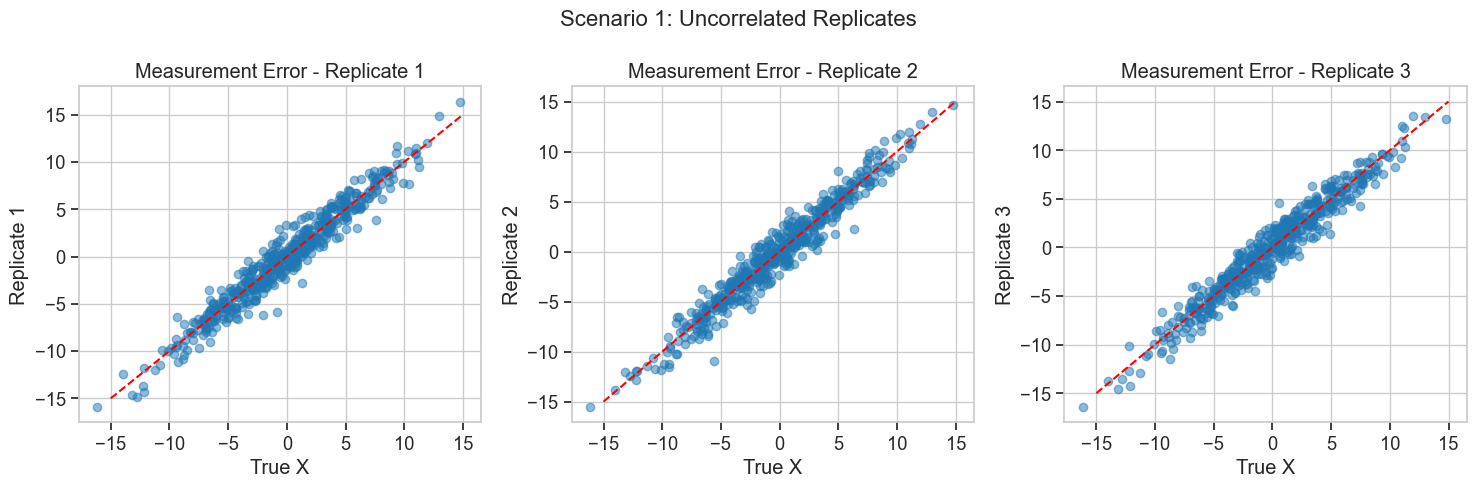

In [41]:
# Plot for scenario 1 (Uncorrelated replicates)
me_error_distribution_scenario_1 = plot_measurement_error(data_scenario1, 1)

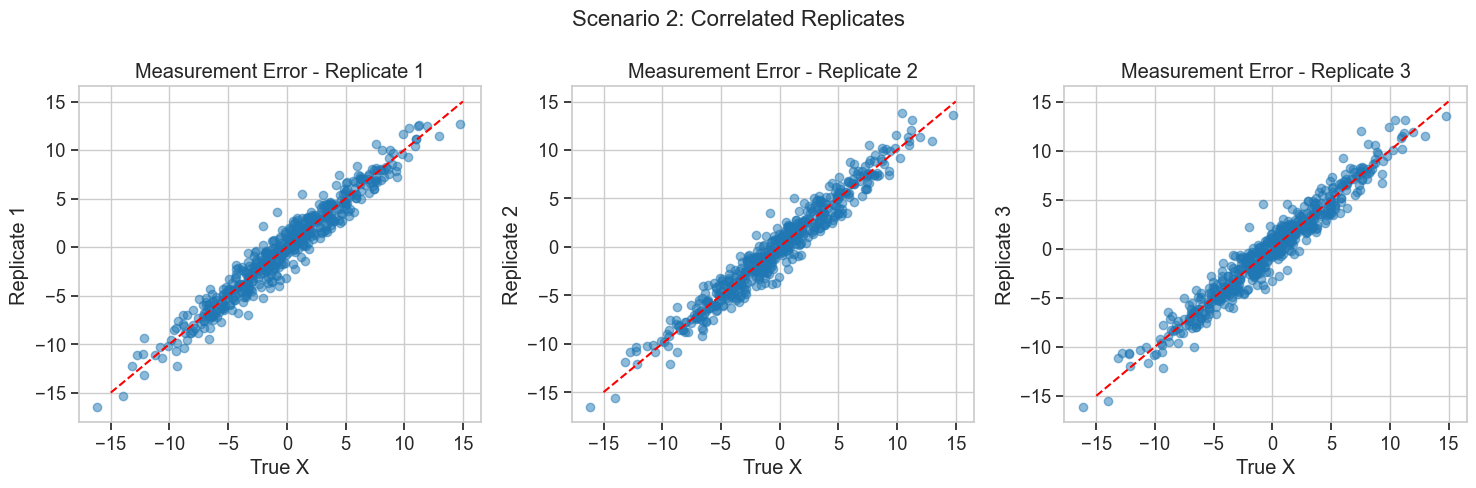

In [42]:
# Plot for scenario 2 (Correlated replicates)
me_error_scenario_2 = plot_measurement_error(data_scenario2, 2)

In [43]:
# Examine the response variables
def plot_responses(data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gaussian responses
    ax1 = axes[0]
    ax1.scatter(data['x_true'], data['y_gaussian'], alpha=0.5)
    ax1.set_xlabel('True X')
    ax1.set_ylabel('Gaussian Response')
    ax1.set_title('Gaussian Response vs. True Covariate')
    
    # Add the true functional relationship
    x_line = np.linspace(min(data['x_true']), max(data['x_true']), 100)
    y_line = np.sin(x_line)
    ax1.plot(x_line, y_line, 'r-', label='sin(x)')
    ax1.legend()
    
    # Beta responses
    ax2 = axes[1]
    ax2.scatter(data['x_true'], data['y_beta'], alpha=0.5)
    ax2.set_xlabel('True X')
    ax2.set_ylabel('Beta Response')
    ax2.set_title('Beta Response vs. True Covariate')
    
    plt.suptitle('Response Variables', fontsize=16)
    plt.tight_layout()
    return fig

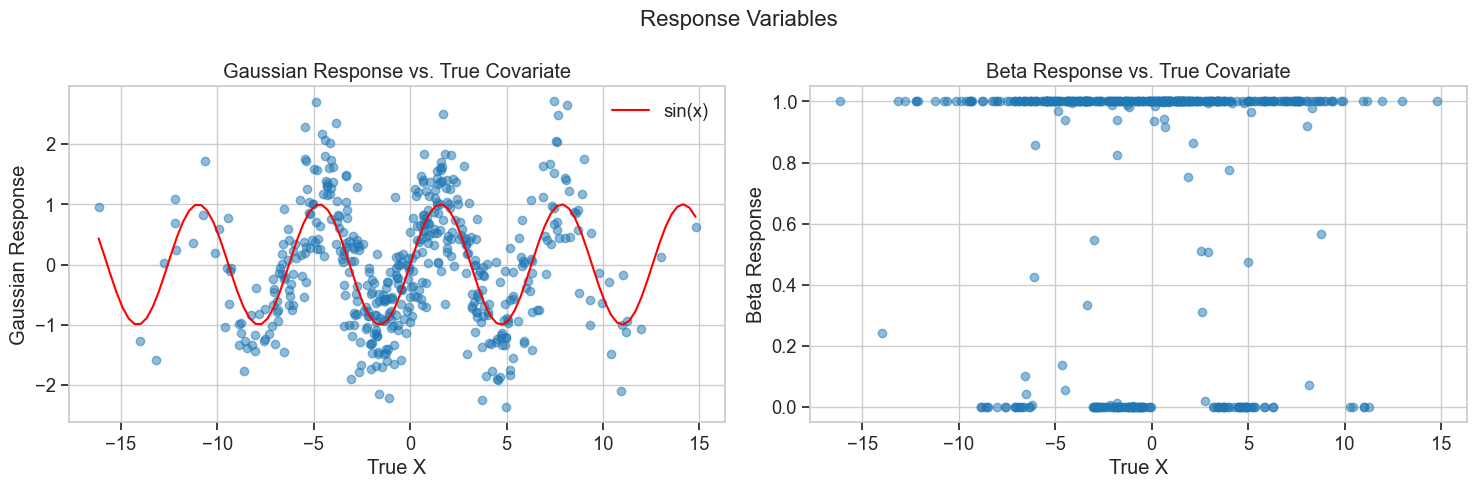

In [45]:
# Plot responses
responses_scenario_1 = plot_responses(data_scenario1)

In [46]:
# Run a full simulation
# This takes onyl ~6s (expected way more)

# Run simulations for scenario 1
print("Running simulations for Scenario 1...")
all_simulations_scenario1 = run_simulations(
    n_simulations=n_simulations,
    n_samples=n_samples,
    n_replicates=n_replicates,
    scenario=1
)

print(f"Generated {n_simulations} simulations for scenario1")

Running simulations for Scenario 1...
Generated 100 simulations for scenario1


In [47]:
# Run simulations for scenario 2
print("Running simulations for Scenario 2...")
all_simulations_scenario2 = run_simulations(
    n_simulations=n_simulations,
    n_samples=n_samples,
    n_replicates=n_replicates,
    scenario=2
)
print(f"Generated {n_simulations} simulations for scenario2")

Running simulations for Scenario 2...
Generated 100 simulations for scenario2


In [48]:
# Function for saving the data
def save_simulation_data(data, scenario, n_samples, n_replicates, full_simulation=False):
    """Save the simulation data to CSV files"""
    if full_simulation:
        filename = f"simulation_data_scenario{scenario}_nsim{n_simulations}_samples{n_samples}_rep{n_replicates}.csv"
    else:
        filename = f"example_data_scenario{scenario}_samples{n_samples}_rep{n_replicates}.csv"
    
    data.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

In [49]:
# Uncomment to save the example datasets
save_simulation_data(data_scenario1, 1, n_samples, n_replicates)
save_simulation_data(data_scenario2, 2, n_samples, n_replicates)

Data saved to example_data_scenario1_samples500_rep3.csv
Data saved to example_data_scenario2_samples500_rep3.csv


In [50]:
# Save the full simulation datasets
save_simulation_data(all_simulations_scenario1, 1, n_samples, n_replicates, full_simulation=True)
save_simulation_data(all_simulations_scenario2, 2, n_samples, n_replicates, full_simulation=True)

Data saved to simulation_data_scenario1_nsim100_samples500_rep3.csv
Data saved to simulation_data_scenario2_nsim100_samples500_rep3.csv
